# Coding Assignment "FL Algorithms"

## 1. Preparation

### 1.1 Libraries

In [3]:
import numpy as np 
import pandas as pd 
from datetime import datetime
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# We will use networx objects to store empircial graphs, local datasets and models
import networkx as nx 
from sklearn.neighbors import kneighbors_graph
from numpy import linalg as LA

### 1.2 Helper functions

In [4]:
# The function generates a scatter plot of nodes (=FMI stations) using 
# latitude and longitude as coordinates. 
def plotFMI(G_FMI): 
    coords = [G_FMI.nodes[i]['coord'] for i in range(num_stations)]
    df_coords = pd.DataFrame(coords,columns=['latitude','longitude'])
    coords = np.hstack((df_coords["latitude"].to_numpy().reshape(-1,1),df_coords["longitude"].to_numpy().reshape(-1,1)))
    # Create a plot
    fig, ax = plt.subplots()
    # Draw nodes
    for node in G_FMI.nodes:
        ax.scatter(coords[node,1], coords[node,0], color='black', s=4, zorder=5)  # zorder ensures nodes are on top of edges
    # Add labels
    for node in G_FMI.nodes:
        ax.text(coords[node,1]+0.1, coords[node,0]+0.2, str(node), fontsize=8, ha='center', va='center', color='black', fontweight='bold')
    # Draw edges
    for edge in G_FMI.edges:
        ax.plot([coords[edge[0],1],coords[edge[1],1]], [coords[edge[0],0],coords[edge[1],0]], linestyle='-', color='gray')

    ax.set_xlabel('longitude')
    ax.set_ylabel('latitude')
    ax.set_title('FMI stations')
    plt.show()
    
    
# The function connects each FMI station with 
# the nearest neighbours. 
def add_edges(graph, numneighbors=4):
    coords = [graph.nodes[i]['coord'] for i in range(num_stations)]
    df_coords = pd.DataFrame(coords,columns=['latitude','longitude'])
    coords = np.hstack((df_coords["latitude"].to_numpy().reshape(-1,1),df_coords["longitude"].to_numpy().reshape(-1,1)))
    A = kneighbors_graph(coords, numneighbors, mode='connectivity', include_self=False)
    nrnodes = len(graph.nodes)
    for iter_i in range(nrnodes): 
        for iter_ii in range(nrnodes): 
            if iter_i != iter_ii : 
                if A[iter_i,iter_ii]> 0 :
                    graph.add_edge(iter_i, iter_ii)
    return graph

# The function below extracts a feature and label from each row 
# of dataframe df. Each row is expected to hold a FMI weather 
# measurement with cols "Latitude", "Longitude", "temp", "Timestamp" 
# returns numpy arrays X, y.
def ExtractFeaureMatrixLabvelVector(data):
    nrfeatures = 7 
    nrdatapoints = len(data)
    X = np.zeros((nrdatapoints, nrfeatures))
    y = np.zeros((nrdatapoints, 1))

    # Iterate over all rows in dataframe and create corresponding feature vector and label 
    for ind in range(nrdatapoints):
        # latitude of FMI station, normalized by 100 
        lat = float(data['Latitude'].iloc[ind])/100
        # longitude of FMI station, normalized by 100
        lon = float(data['Longitude'].iloc[ind])/100
        # temperature value of the data point 
        tmp = data['temp'].iloc[ind]
        # read the date and time of the temperature measurement 
        date_object = datetime.strptime(data['Timestamp'].iloc[ind], '%Y-%m-%d %H:%M:%S')
        # Extract year, month, day, hour, and minute. Normalize these values 
        # to ensure that the features are in range [0,1].
        year = float(date_object.year)/2025
        month = float(date_object.month)/13
        day = float(date_object.day)/32
        hour = float(date_object.hour)/25
        minute = float(date_object.minute)/61
        X[ind,:] = [lat, lon, year, month, day, hour, minute]
        y[ind,:] = tmp

    return X, y

## 2 Data

### 2.1 Dataset

In [5]:
# Import the weather measurements.
data = pd.read_csv('Assignment_MLBasicsData.csv')

# We consider each temperature measurement (=a row in dataframe) as a 
# separate data point.
# Get the numbers of data points and the unique stations.
num_stations = len(data.name.unique())
num_datapoints = len(data)

### 2.2 Empirical graph

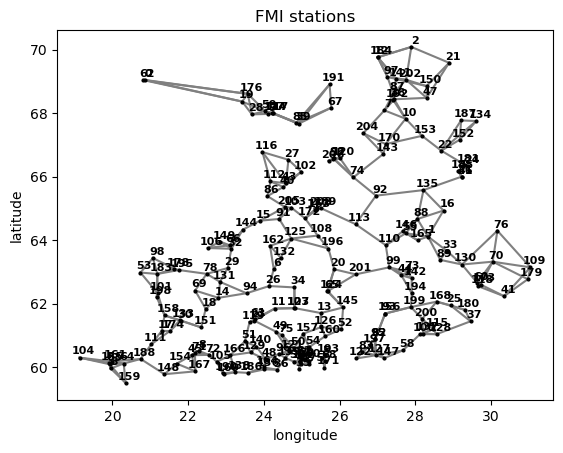

In [7]:
# Define the random seed and the fraction of validation set for
# the train_test_split() function. 
test_size = 0.2
seed = 1

#############
# In what follows, we 
# 1. construct the empirical graph G_FMI as a networkx.Graph() object,
# 2. add a single node for each station,
# 3. for each node add the following attributes: 
#   'samplesize' - The number of measurements of the i-th weather station,
#   'name' - The name of the i-th weather station,
#   'coord' - The coordinates of the i-th weather station,
#   'X_train', 'y_train', 'X_val', and 'y_val' - the training and validation data,
#   'weights' - the i-th node's model parameters.

# Create a networkX graph
G_FMI = nx.Graph()

# Add a one node per station
G_FMI.add_nodes_from(range(0, num_stations))

for i, station in enumerate(data.name.unique()):
    # Extract data of a certain station
    station_data = data[data.name==station]
    
    # Extract features and labels
    X, y = ExtractFeaureMatrixLabvelVector(station_data)
    
    # Split the dataset into training and validation set. 
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

    localsamplesize = len(y)
    G_FMI.nodes[i]['samplesize'] = localsamplesize # The number of measurements of the i-th weather station
    G_FMI.nodes[i]['name'] = station # The name of the i-th weather station
    G_FMI.nodes[i]['coord'] = (station_data.Latitude.unique()[0], station_data.Longitude.unique()[0]) # The coordinates of the i-th weather station
    G_FMI.nodes[i]['X_train'] = X_train # The training feature matrix for local dataset at node i
    G_FMI.nodes[i]['y_train'] = y_train  # The training label vector for local dataset at node i
    G_FMI.nodes[i]['X_val'] = X_val # The training feature matrix for local dataset at node i
    G_FMI.nodes[i]['y_val'] = y_val  # The training label vector for local dataset at node i
    G_FMI.nodes[i]['weights'] = np.zeros((7,1))

# Add edges between each station and its nearest neighbors.
# NOTE: the node degree might be different for different nodes.
numneighbors = 3
G_FMI = add_edges(G_FMI, numneighbors=numneighbors)

# Visualize the empirical graph.
plotFMI(G_FMI)

## 3. Model

### 3.1 Student task #1 - FedGD

In [8]:
# Define hyperparameters.
max_iter = 1000
alpha = 0.5
l_rate = 0.1

####################TODO####################
# TODO: Implement a FedGD algorithm (Algorithm 3 from the Lecture Notes).

raise NotImplementedError


NotImplementedError: 

In [51]:
# Create the storages for the training and validation errors.
train_errors = np.zeros(num_stations)
val_errors = np.zeros(num_stations)

####################TODO####################
# TODO: Calculate the average (over all nodes) training and validation errors.
# Note: Use mean_squared_error() method for calculating local errors.

raise NotImplementedError
    
# Output the average training and validation errors.
print("The average training error:", np.mean(train_errors))
print("The average validation error:", np.mean(val_errors))

The average training error: 20.518502629831982
The average validation error: 21.03050197347489


### 3.2 Student task #2 - FedSGD

In [53]:
# Define hyperparameters.
max_iter = 1000
alpha = 0.5
l_rate = 0.1
batch_size = 10

####################TODO####################
# TODO: Implement a FedSGD algorithm (Algorithm 4 from the Lecture Notes).

raise NotImplementedError



In [54]:
# Create the storages for the training and validation errors.
train_errors = np.zeros(num_stations)
val_errors = np.zeros(num_stations)

####################TODO####################
# TODO: Calculate the average (over all nodes) training and validation errors.
# Note: Use mean_squared_error() method for calculating local errors.

raise NotImplementedError
      
# Output the average training and validation errors.
print("The average training error:", np.mean(train_errors))
print("The average validation error:", np.mean(val_errors))

The average training error: 20.78811899552608
The average validation error: 21.26316073235711
